<a href="https://colab.research.google.com/github/borasimsek/ai-competition/blob/main/aicompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import zipfile
import os
import cv2
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.applications import ResNet50
from keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers  # Import regularizers
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
# Modeli tanımlama (Daha önceki EfficientNetV2 kodunu kullanabilirsiniz).
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
import os
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Unzip

In [4]:
# Yüklediğiniz zip dosyasının yolunu buraya yazın
zip_file_path = '/content/drive/MyDrive/bosch_ai_competition/train.zip'  # Örneğin dosyanızın adı 'dosya.zip' ise

In [8]:
!unzip '/content/drive/MyDrive/bosch_ai_competition/train.zip' -d '/content/drive/MyDrive/bosch_ai_competition/'


Streaming output truncated to the last 5000 lines.
 extracting: /content/drive/MyDrive/bosch_ai_competition/train/5499.png  
 extracting: /content/drive/MyDrive/bosch_ai_competition/train/55.png  
 extracting: /content/drive/MyDrive/bosch_ai_competition/train/550.png  
 extracting: /content/drive/MyDrive/bosch_ai_competition/train/5500.png  
 extracting: /content/drive/MyDrive/bosch_ai_competition/train/5501.png  
 extracting: /content/drive/MyDrive/bosch_ai_competition/train/5502.png  
 extracting: /content/drive/MyDrive/bosch_ai_competition/train/5503.png  
 extracting: /content/drive/MyDrive/bosch_ai_competition/train/5504.png  
 extracting: /content/drive/MyDrive/bosch_ai_competition/train/5505.png  
 extracting: /content/drive/MyDrive/bosch_ai_competition/train/5506.png  
 extracting: /content/drive/MyDrive/bosch_ai_competition/train/5507.png  
 extracting: /content/drive/MyDrive/bosch_ai_competition/train/5508.png  
 extracting: /content/drive/MyDrive/bosch_ai_competition/train/5

# Preprocessing

In [9]:
import os
os.getcwd()

'/content'

In [10]:
train_data_path = "/content/drive/MyDrive/bosch_ai_competition/train_labels.csv"
train_data = pd.read_csv(train_data_path)
train_data['image_name'] = train_data['image_name'].astype(str)  # Metne dönüştür
images = []
labels = []

In [15]:
print(train_data['label'].value_counts())

label
29    500
11    500
28    500
23    500
96    500
17    500
97    500
80    500
59    500
70    500
64    500
52    500
42    500
21    500
22    500
81    500
78    500
49    500
76    500
14    500
9     500
6     500
20    500
98    500
36    500
55    500
51    500
35    500
92    500
50    500
15    500
46    500
38    500
66    500
69    500
95    500
93    500
94    500
68    500
34    500
67    500
30    500
26    500
48    500
79    500
7     500
12    500
5     500
60    500
91    500
Name: count, dtype: int64


In [11]:
for index, row in train_data.iterrows():
    # Dosya yolunu oluştururken .png uzantısını ekleyin
    img_path = os.path.join("/content/drive/MyDrive/bosch_ai_competition/train", f"{row['image_name']}.png")

    if not os.path.exists(img_path):
        print(f"Dosya bulunamadı: {img_path}")  # Hata mesajı
    else:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Resim açılamadı: {img_path}")  # Resim açılmadıysa hata mesajı
        else:
            img = cv2.resize(img, (32, 32))  # Resmi yeniden boyutlandırma
            images.append(img)
            labels.append(row['label'])

# Listeleri NumPy dizilerine dönüştürün
images = np.array(images)
labels = np.array(labels)

print(f"Toplam {len(images)} resim işlendi.")


Toplam 25000 resim işlendi.


In [ ]:
# images[1], labels[1] debugging

# Encoding

In [12]:
# Etiketleri Sayısal Formata Çevirme
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)  # String -> Integer
num_classes = len(label_encoder.classes_)  # Sınıf sayısı

# One-Hot Encoding
labels_one_hot = to_categorical(labels_encoded, num_classes)

X_train, X_val, y_train, y_val = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)


In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(4).shuffle(buffer_size=1000)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(4)

In [27]:
# Veri Augmentasyonu
def augment(image, label):
    seed1 = tf.random.uniform([2], minval=0, maxval=int(1e6), dtype=tf.int32)
    seed2 = tf.random.uniform([2], minval=0, maxval=int(1e6), dtype=tf.int32)

    image = tf.image.stateless_random_flip_left_right(image, seed=seed1)
    image = tf.image.stateless_random_brightness(image, max_delta=0.2, seed=seed2)
    image = tf.image.stateless_random_contrast(image, lower=0.8, upper=1.2, seed=seed1)

    image = tf.image.resize(image, [36, 36])
    image = tf.image.random_crop(image, [32, 32, 3])

    return image, label

In [28]:
# Create datasets without augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .shuffle(buffer_size=1000) \
    .batch(4) \
    .prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
    .batch(4) \
    .prefetch(tf.data.AUTOTUNE)


In [29]:
num_classes=50

# EfficientNetV2 Modeli
base_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=(32, 32, 3),
)
base_model.trainable = False  # Fine-tuning için başta dondurulmuş olmalı

for layer in base_model.layers[:-10]:
    layer.trainable = False

In [36]:
# Model Yapısı
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])
#2. Model Denemesi
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [37]:
num_classes

50

In [38]:
# Model Eğitimi
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.0196 - loss: 4.3324 - val_accuracy: 0.0174 - val_loss: 3.9131 - learning_rate: 5.9049e-04
Epoch 2/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.0195 - loss: 3.9128 - val_accuracy: 0.0488 - val_loss: 3.7148 - learning_rate: 3.4868e-04
Epoch 3/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.0542 - loss: 3.7094 - val_accuracy: 0.1160 - val_loss: 3.4384 - learning_rate: 2.0589e-04
Epoch 4/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.1030 - loss: 3.4798 - val_accuracy: 0.1504 - val_loss: 3.2566 - learning_rate: 1.2158e-04
Epoch 5/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.1339 - loss: 3.3262 - val_accuracy: 0.1748 - val_loss: 3.1788 - learning_rate: 7.1790e-05
Epoch 6/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.1485 - loss: 3.2288 - val_accuracy: 0.1846 - val_loss: 3.1271 - learning_rate: 4.2391e-05
Epoch 7/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 

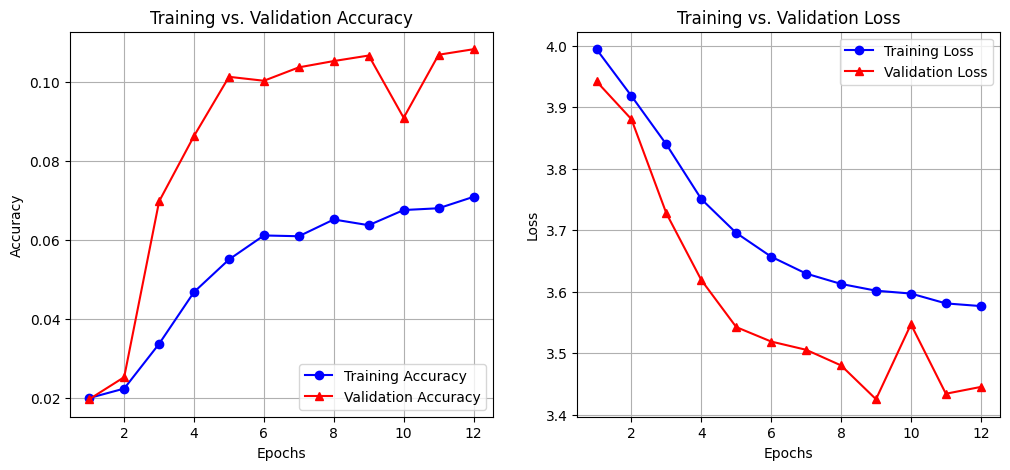

In [24]:
# Extract training history
history_dict = history.history

# Accuracy and loss values
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_acc) + 1)  # Define the number of epochs

# Set figure size
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')  # Blue circles
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')  # Red triangles
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid()

# Plot Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid()

# Display plots
plt.show()